In [46]:
import os
import re
import sys
import time
import random
import pickle
import datetime
import pandas as pd
import seaborn as sns
from pprint import pprint
from matplotlib import pyplot as plt

from collections import Counter

%matplotlib inline

In [99]:
import PyPDF2
from tqdm import tqdm
from sklearn.decomposition import PCA
from IPython.display import IFrame
import plotly.graph_objects as go
import numpy as np
import plotly.express as px
from plotly.subplots import make_subplots


import spacy
import fasttext

In [3]:
# with open('data/ramayan_pages_as_list.pkl', 'rb') as file:
#     data = pickle.load(file)

with open('data/RamayanEnglish.txt', 'r') as file:
    data = file.read()

In [4]:
data = re.sub(pattern='\s{2,}', repl=' ', string=data)

In [5]:
# Load the English language model
nlp = spacy.load("en_core_web_sm")

# Process the long paragraph with spaCy
doc = nlp(data)

# Extract sentences from the processed document
sentences = [sent.text for sent in doc.sents]

# The 'sentences' list now contains each sentence as a separate element
final_data = [[sent] for sent in sentences]

In [6]:
def preprocess_text(text):
    # Process the text using spaCy
    doc = nlp(text)

    # Remove stop words, punctuation, and special characters
    tokens = [token.text.lower() for token in doc if not (token.is_stop or token.is_punct or token.is_space or token.is_digit)]

    # Join the tokens back into a string
    processed_text = ' '.join(tokens)

    return processed_text

In [7]:
final_data = [[preprocess_text(line[0])] for line in final_data]

In [8]:
data_deep_cleaned = ' '.join([line[0] for line in final_data])

In [9]:
with open('./data/RamayanEnglishDeepCleaned.txt', 'w') as f:
    f.write(data_deep_cleaned)

### Visualisation 1.0

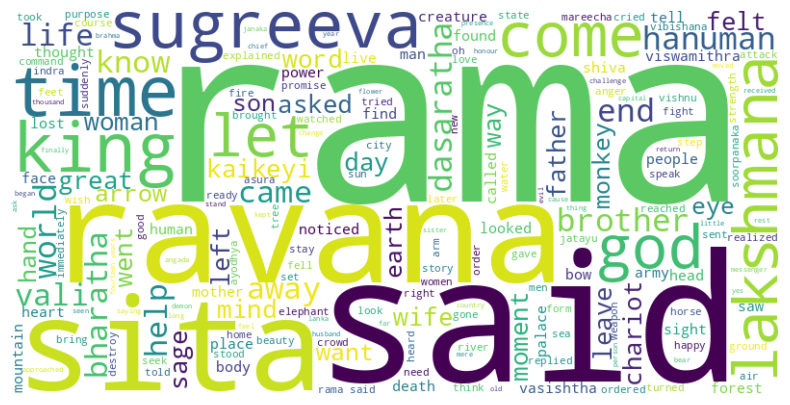

In [22]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(data_deep_cleaned)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### CBOW Model

In [10]:
model = fasttext.train_unsupervised(
    './data/RamayanEnglishDeepCleaned.txt',
    model='cbow',
    dim=100,  # Size of vectors default is 100
    epoch=1000, 
    lr=0.05,
    minn=2,  # Subwords default is 2 (subwords are all the substrings contained in a word between the minimum size (minn) and the maximal size (maxn))
    maxn=6,  # Subwords default is 6 (subwords are all the substrings contained in a word between the minimum size (minn) and the maximal size (maxn))
    verbose=2,
    thread=10
)

Read 0M words
Number of words:  1171
Number of labels: 0
Progress: 100.0% words/sec/thread:   60076 lr:  0.000000 avg.loss:  1.073841 ETA:   0h 0m 0s


In [11]:
model.get_word_vector("Ram")

array([ 1.9491905 ,  0.4838519 , -0.1388232 ,  0.79613745, -1.9103374 ,
        0.1950943 ,  3.692973  ,  0.05654488,  0.08889218, -1.910757  ,
       -0.9392977 , -2.2462087 , -0.22419024,  0.65840113,  1.3114274 ,
       -1.5604627 ,  0.09338117,  0.22976156,  0.6578967 , -1.2434477 ,
        0.02565575,  3.8072984 , -2.5022132 ,  2.3286521 ,  3.7965913 ,
        0.5585634 , -2.0977857 , -0.7292966 , -1.3483295 ,  0.9343201 ,
        0.5926764 ,  1.0111021 , -1.4652054 , -0.7776084 ,  0.82004035,
       -1.7310101 , -0.58290684, -1.1092799 ,  3.4470005 , -1.4333334 ,
       -0.4813221 ,  0.28112435,  1.1409485 ,  0.5470427 , -3.7526467 ,
        0.34156746, -1.6548687 ,  1.8438752 ,  1.4320629 ,  2.2045896 ,
        1.4325638 , -2.130839  , -2.3226922 ,  1.3134004 ,  0.9241921 ,
       -2.6275427 ,  1.5182973 , -1.6075152 ,  1.1692266 ,  1.0607802 ,
       -0.45930815, -2.2362764 , -0.35200417, -0.7776908 , -1.4133219 ,
        4.172905  , -1.1565236 , -2.310562  , -3.2442498 , -0.60

### Visualisation 2.0

In [17]:
no_of_words = 300
# words = random.sample(model.words, no_of_words)
words = model.words

embeddings = [model.get_word_vector(word) for word in words]

# Perform PCA to reduce the dimensionality of the embeddings
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Visualize the embeddings
plt.figure(figsize=(300, 300))
for i, word in enumerate(words):
    x, y = reduced_embeddings[i]
    plt.scatter(x, y)
    plt.annotate(
        word, 
        xy=(x, y), 
        xytext=(5, 2),
        textcoords='offset points',
        ha='right', 
        va='bottom')

# plt.show()
plt.savefig('./output/1.CBOW_2D_ramayan_embedding_plot_all_words.png')

In [107]:
no_of_words = 300
# words = random.sample(model.words, no_of_words)
words = model.words[:no_of_words]

embeddings = [model.get_word_vector(word) for word in words]

# Perform PCA to reduce the dimensionality of the embeddings
pca = PCA(n_components=3)
reduced_embeddings = pca.fit_transform(embeddings)
reduced_embeddings_df = pd.DataFrame(data=reduced_embeddings, columns=['pca1', 'pca2', 'pca3'])
reduced_embeddings_df['Words'] = words

# Visualize the embeddings
coordinate_label = reduced_embeddings_df.values
x = reduced_embeddings_df.values
y = reduced_embeddings_df.values
z = reduced_embeddings_df.values

fig = px.scatter_3d(
    data_frame=reduced_embeddings_df, 
    x='pca1', 
    y='pca2', 
    z='pca3',
    # hover_data='Words',
    hover_name='Words',
    # color='species',
    text='Words'
)

# Save the figure as an HTML file
file_name = './output/6.CBOW_3D_ramayan_embedding_plot_random_300words.html'
fig.write_html(file_name)

Display the HTML file in the notebook
IFrame(src=file_name, width=800, height=600)

### Nearest neighbor queries
A simple way to check the quality of a word vector is to look at its nearest neighbors. This give an intuition of the type of semantic information the vectors are able to capture.

In [108]:
global data_deep_cleaned, model

In [109]:
def get_nearest_neighbors(target_word):
    print(f'[+] Is "{target_word}" present in the data: {target_word in data_deep_cleaned}')
    data = model.get_nearest_neighbors(target_word)
    data.insert(0, (1, target_word.upper()))
    df = pd.DataFrame(data=data, columns=['Probability', 'Predicted Word'])
    df = df[['Predicted Word', 'Probability']]
    print(df.to_string())
    print()

In [110]:
get_nearest_neighbors('ram')
get_nearest_neighbors('sita')
get_nearest_neighbors('supernatural')
get_nearest_neighbors('brother')
get_nearest_neighbors('mother')
get_nearest_neighbors('power')

[+] Is "ram" present in the data: True
   Predicted Word  Probability
0             RAM     1.000000
1          ashram     0.672683
2       nandigram     0.573173
3            rain     0.428527
4           rainy     0.390744
5            rama     0.350912
6            rage     0.340663
7            form     0.332743
8           claim     0.329388
9    preparations     0.315720
10          rains     0.293929

[+] Is "sita" present in the data: True
   Predicted Word  Probability
0            SITA     1.000000
1       presently     0.373696
2       lakshmana     0.363059
3       hesitated     0.294088
4           crowd     0.292718
5           women     0.282330
6            spot     0.280368
7         farther     0.275210
8             saw     0.264518
9             hut     0.261681
10         golden     0.259918

[+] Is "supernatural" present in the data: True
   Predicted Word  Probability
0    SUPERNATURAL     1.000000
1       naturally     0.400113
2          weapon     0.368360
3  

### Word analogies
Example, we can see if our model can guess what is to France, and what Berlin is to Germany.

In [111]:
model.get_analogies("ram", "sita", "dashratha")

[(0.6416812539100647, 'ashram'),
 (0.42854294180870056, 'nandigram'),
 (0.3421267569065094, 'rainy'),
 (0.3049022853374481, 'asthra'),
 (0.3002665936946869, 'claim'),
 (0.27976226806640625, 'bharatha'),
 (0.2758650481700897, 'dasaratha'),
 (0.268572062253952, 'asthras'),
 (0.26070883870124817, 'aim'),
 (0.25370487570762634, 'rare')]

In [112]:
model.get_analogies("ram", "lakshman", "ravan")

[(0.4568515121936798, 'ashram'),
 (0.4559316337108612, 'rain'),
 (0.4506568908691406, 'jambavan'),
 (0.45054805278778076, 'nandigram'),
 (0.41747236251831055, 'rainy'),
 (0.3456061780452728, 'wisdom'),
 (0.3360068202018738, 'speech'),
 (0.32428568601608276, 'rains'),
 (0.31609368324279785, 'rage'),
 (0.28319549560546875, 'armies')]

In [114]:
model.get_analogies("ram", "ravan", "lakshman")

[(0.5861538648605347, 'ashram'),
 (0.4793735444545746, 'lakshmana'),
 (0.42459923028945923, 'nandigram'),
 (0.33120957016944885, 'preparations'),
 (0.30597490072250366, 'youth'),
 (0.2979247570037842, 'claim'),
 (0.2948576509952545, 'gate'),
 (0.2910178005695343, 'rama'),
 (0.2712043821811676, 'firm'),
 (0.26913487911224365, 'fire')]

### Save the model

In [115]:
model.save_model("./assets/cbow_ramayan_word2vec.bin")

### Skip-Gram Model

In [116]:
model = fasttext.train_unsupervised(
    './data/RamayanEnglishDeepCleaned.txt',
    model='skipgram',
    dim=100,  # Size of vectors default is 100
    epoch=1000, 
    lr=0.05,
    minn=2,  # Subwords default is 2 (subwords are all the substrings contained in a word between the minimum size (minn) and the maximal size (maxn))
    maxn=6,  # Subwords default is 6 (subwords are all the substrings contained in a word between the minimum size (minn) and the maximal size (maxn))
    verbose=2,
    thread=10
)

Read 0M words
Number of words:  1171
Number of labels: 0
Progress: 100.0% words/sec/thread:   53696 lr:  0.000000 avg.loss:  1.605472 ETA:   0h 0m 0s


In [123]:
get_nearest_neighbors('ram')
get_nearest_neighbors('sita')
get_nearest_neighbors('supernatural')
get_nearest_neighbors('brother')
get_nearest_neighbors('mother')
get_nearest_neighbors('power')

[+] Is "ram" present in the data: True
   Predicted Word  Probability
0             RAM     1.000000
1          ashram     0.688035
2       nandigram     0.672279
3           hours     0.478898
4           brief     0.438387
5          spirit     0.424429
6            rare     0.422352
7        ramayana     0.419204
8         ayodhya     0.395495
9        bharatha     0.391253
10         appear     0.385432

[+] Is "sita" present in the data: True
   Predicted Word  Probability
0            SITA     1.000000
1            rama     0.600165
2          ravana     0.501524
3            said     0.477253
4       lakshmana     0.421311
5         hanuman     0.418043
6          moment     0.414598
7             saw     0.410848
8            left     0.396780
9            went     0.396760
10           love     0.395991

[+] Is "supernatural" present in the data: True
   Predicted Word  Probability
0    SUPERNATURAL     1.000000
1          forces     0.448836
2       sacrifice     0.444910
3  

In [124]:
model.get_analogies("ram", "sita", "dashratha")

[(0.7209730744361877, 'ashram'),
 (0.4754936397075653, 'nandigram'),
 (0.4415220618247986, 'hours'),
 (0.43834665417671204, 'rainy'),
 (0.3849462866783142, 'sandals'),
 (0.37351852655410767, 'bharatha'),
 (0.3711908161640167, 'sathrugna'),
 (0.3701900541782379, 'close'),
 (0.36598077416419983, 'appear'),
 (0.36031317710876465, 'dawn')]

In [125]:
model.get_analogies("ram", "lakshman", "ravan")

[(0.5362528562545776, 'nandigram'),
 (0.48680514097213745, 'jambavan'),
 (0.4717338979244232, 'spirit'),
 (0.4530481696128845, 'hours'),
 (0.4528197944164276, 'ashram'),
 (0.42078307271003723, 'ramayana'),
 (0.41478633880615234, 'wisdom'),
 (0.4017842710018158, 'action'),
 (0.400738388299942, 'gigantic'),
 (0.4002922773361206, 'yama')]

In [127]:
model.get_analogies("ram", "ravan", "lakshman")

[(0.5704070925712585, 'lakshmana'),
 (0.5054774880409241, 'ashram'),
 (0.37439921498298645, 'nandigram'),
 (0.35658788681030273, 'suffering'),
 (0.33417215943336487, 'left'),
 (0.3340228497982025, 'palace'),
 (0.32884880900382996, 'stay'),
 (0.32579168677330017, 'bharatha'),
 (0.3111022114753723, 'spend'),
 (0.2995305061340332, 'youth')]

### Visualisation 2.0

In [122]:
no_of_words = 300
words = random.sample(model.words, no_of_words)
# words = model.words

embeddings = [model.get_word_vector(word) for word in words]

# Perform PCA to reduce the dimensionality of the embeddings
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Visualize the embeddings
plt.figure(figsize=(300, 300))
for i, word in enumerate(words):
    x, y = reduced_embeddings[i]
    plt.scatter(x, y)
    plt.annotate(
        word, 
        xy=(x, y), 
        xytext=(5, 2),
        textcoords='offset points',
        ha='right', 
        va='bottom')

# plt.show()
plt.savefig('./output/1.SKIPGRAM_2D_ramayan_embedding_plot_random_300words.png')

In [119]:
no_of_words = 300
words = random.sample(model.words, no_of_words)
# words = model.words[:no_of_words]

embeddings = [model.get_word_vector(word) for word in words]

# Perform PCA to reduce the dimensionality of the embeddings
pca = PCA(n_components=3)
reduced_embeddings = pca.fit_transform(embeddings)
reduced_embeddings_df = pd.DataFrame(data=reduced_embeddings, columns=['pca1', 'pca2', 'pca3'])
reduced_embeddings_df['Words'] = words

# Visualize the embeddings
coordinate_label = reduced_embeddings_df.values
x = reduced_embeddings_df.values
y = reduced_embeddings_df.values
z = reduced_embeddings_df.values

fig = px.scatter_3d(
    data_frame=reduced_embeddings_df, 
    x='pca1', 
    y='pca2', 
    z='pca3',
    # hover_data='Words',
    hover_name='Words',
    # color='species',
    text='Words'
)

# Save the figure as an HTML file
file_name = './output/6.SKIPGRAM_3D_ramayan_embedding_plot_random_300words.html'
fig.write_html(file_name)

# Display the HTML file in the notebook
IFrame(src=file_name, width=800, height=600)

In [128]:
model.save_model("./assets/skipgram_ramayan_word2vec.bin")